# Introduction to Tidy Finance

## Working with stock market data

In [2]:
import pandas as pd

In [3]:
prices=pd.read_csv(r'D:/Tidy/AAPL.csv')
prices['date'] = pd.to_datetime(prices['date'])
prices

,symbol,date,open,high,low,close,adjusted,volume
0,AAPL,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.853356,535796800
1,AAPL,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.781409,512377600
2,AAPL,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.792843,778321600
3,AAPL,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.724232,767972800
4,AAPL,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.758538,460734400
...,...,...,...,...,...,...,...,...
5654,AAPL,2022-06-23,136.820007,138.589996,135.630005,138.270004,138.078201,72433800
5655,AAPL,2022-06-24,139.899994,141.910004,139.770004,141.660004,141.463501,89116800
5656,AAPL,2022-06-27,142.699997,143.490005,140.970001,141.660004,141.463501,70207900
5657,AAPL,2022-06-28,142.130005,143.419998,137.320007,137.440002,137.249359,67083400


The function `pd.read_csv()` can read a csv file and returns a dataframe with eight quite self-explanatory columns: symbol, date, the market prices at the open, high, low and close, the daily volume (in number of traded shares), and the adjusted price in USD. The adjusted prices are corrected for anything that might affect the stock price after the market closes, e.g., stock splits and dividends. These actions affect the quoted prices, but they have no direct impact on the investors who hold the stock. Therefore, we often rely on adjusted prices when it comes to analyzing the returns an investor would have earned by holding the stock continuously.

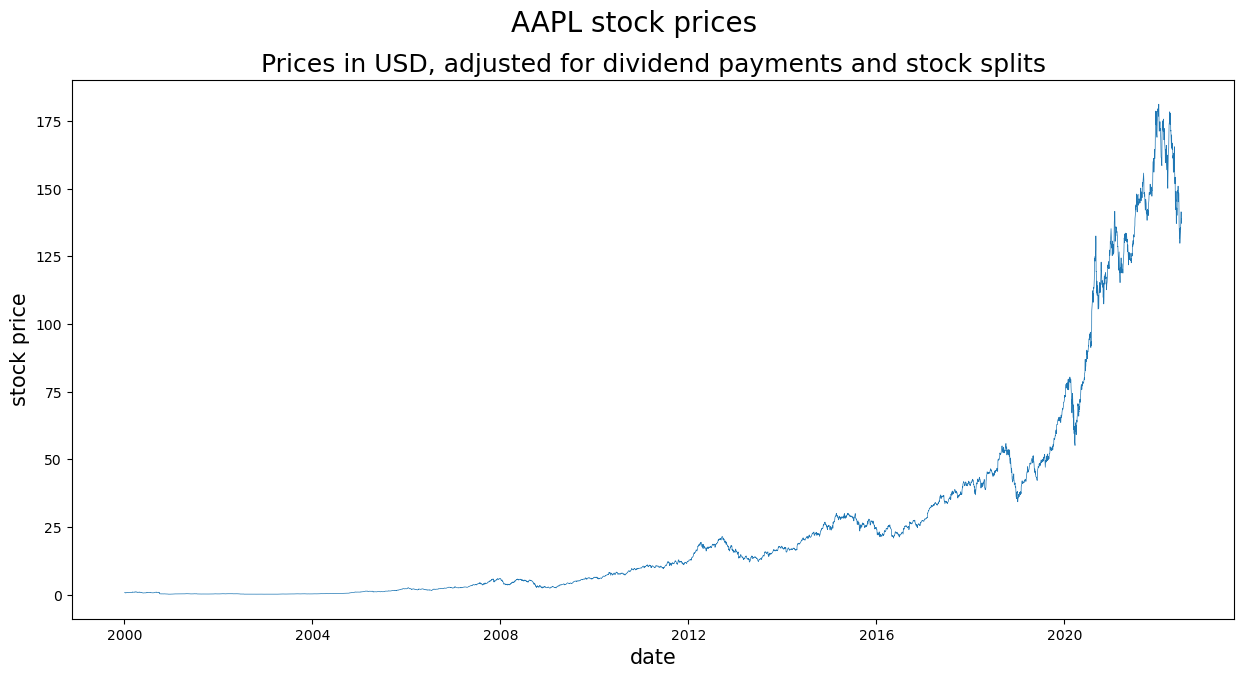

In [4]:
import matplotlib.pyplot as plt
plt.style.use('default')
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(prices['date'], prices['adjusted'], linewidth=0.5)
fig.suptitle('AAPL stock prices',fontsize=20)
ax.set_title('Prices in USD, adjusted for dividend payments and stock splits',fontsize=18)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('stock price',fontsize=15)
plt.show()

Instead of analyzing prices, we compute daily returns defined as $(p_t - p_{t-1}) / p_{t-1} = p_t / p_{t-1} - 1$ where $p_t$ is the adjusted day $t$ price. 
In that context, the function `pct_change()` is helpful, which can return the return directly. 

In [5]:
prices['ret'] = prices.adjusted.pct_change(1)
returns = prices[['adjusted','date','ret']]

Note that the first entry naturally contains a missing value (`nan`) because there is no previous price. 
Obviously, the use of `pct_change()` would be meaningless if the time series is not ordered by date. 
Additionally, the computations require that the time series is ordered by date. 

For the upcoming examples, we remove missing values as these would require separate treatment when computing, e.g., sample averages. In general, however, make sure you understand why `nan` values occur and carefully examine if you can simply get rid of these observations. 

In [6]:
returns=returns.dropna()
returns

,adjusted,date,ret
1,0.781409,2000-01-04,-0.084311
2,0.792843,2000-01-05,0.014633
3,0.724232,2000-01-06,-0.086538
4,0.758538,2000-01-07,0.047369
5,0.745197,2000-01-10,-0.017588
...,...,...,...
5654,138.078201,2022-06-23,0.021574
5655,141.463501,2022-06-24,0.024517
5656,141.463501,2022-06-27,0.000000
5657,137.249359,2022-06-28,-0.029790


Next, we visualize the distribution of daily returns in a histogram. For convenience, we multiply the returns by 100 to get returns in percent for the visualizations. 
Additionally, we add a dashed red line that indicates the 5\% quantile of the daily returns to the histogram, which is a (crude) proxy for the worst return of the stock with a probability of at least 5\%. 
The 5\% quantile is closely connected to the (historical) Value-at-risk, a risk measure commonly monitored by regulators. 

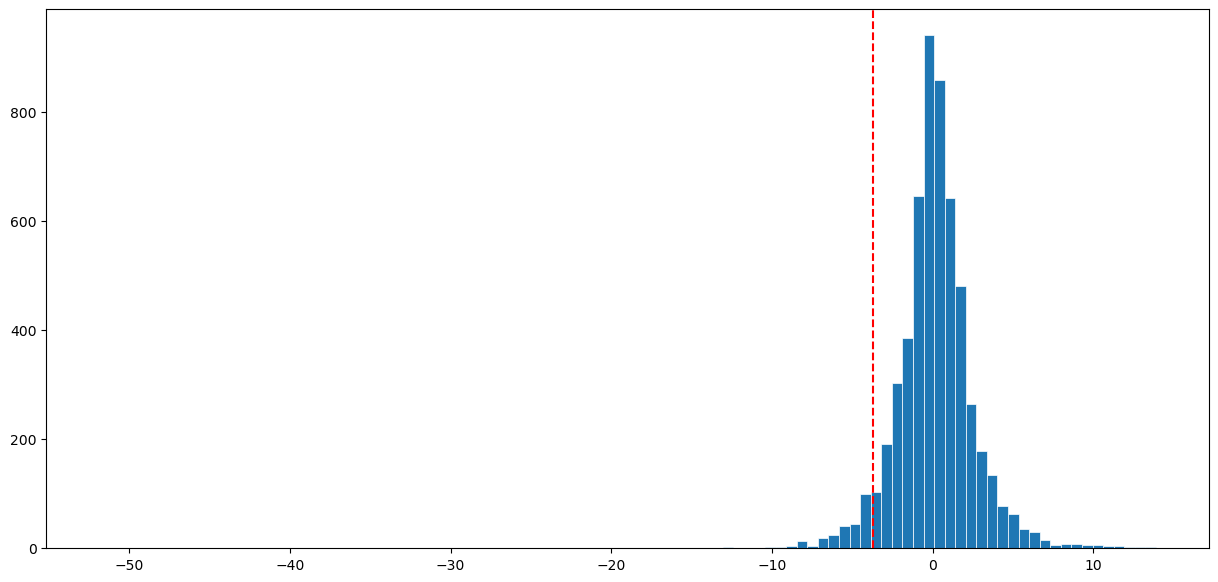

In [7]:
fig, ax = plt.subplots(figsize = (15,7))
ax.hist(returns['ret']*100, bins=100, linewidth=0.5, edgecolor="white")
plt.axvline(x = returns['ret'].quantile(.05)*100, color = 'r',linestyle="dashed")
plt.show()

Here, `bins = 100` determines the number of bins used in the illustration and hence implicitly the width of the bins. 
Before proceeding, make sure you understand how to use the plt `plt.axvline()` to add a dotted red line that indicates the 5\% quantile of the daily returns. 
A typical task before proceeding with *any* data is to compute summary statistics for the main variables of interest. 

In [8]:
returns_summery=pd.DataFrame({"daily_mean":returns.ret.mean()* 100,
                              "daily_max":returns.ret.max()* 100,
                              "daily_min":returns.ret.min()* 100},index=['AAPL'])
returns_summery

,daily_mean,daily_max,daily_min
AAPL,0.123141,13.904951,-51.86916


We see that the maximum *daily* return was around `returns.ret.mean() * 100` percent. Not surprisingly, perhaps, however, the daily average return is close to but slightly above 0. 
In line with the illustration above, the large losses on the day with the minimum returns indicate a strong asymmetry in the distribution of returns.     
You can also compute these summary statistics for each year individually by imposing `groupby('year')`, where the call `dt.year` returns the year. More specifically, the few lines of code `agg()` and  `describe()`below compute the summary statistics from above for individual groups of data, defined by year. The summary statistics therefore allow an eyeball analysis of the time-series dynamics of the return distribution. 

In [9]:
import numpy as np
import datetime as dt
returns['year']=returns.date.dt.year
returns.groupby('year')['ret'].agg([('daily_mean',  lambda x: x.mean()*100 ),('daily_max',  lambda x: x.max()*100 ),('daily_min',  lambda x: x.min()*100 )] )

,daily_mean,daily_max,daily_min
year,,,
2000,-0.345686,13.685852,-51.869160
2001,0.232905,12.856604,-17.171197
2002,-0.121235,8.455925,-15.037415
2003,0.185687,11.349452,-8.141981
2004,0.470227,13.157269,-5.578396
2005,0.348998,9.116744,-9.210579
2006,0.094950,11.829911,-6.332608
2007,0.366398,10.535860,-7.020577
2008,-0.264584,13.904951,-17.919525


In [10]:
returns.groupby('year').apply(lambda x:x.ret.describe())

ret,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2000,251.0,-0.003457,0.054940,-0.518692,-0.034424,-0.001702,0.027153,0.136859
2001,248.0,0.002329,0.039338,-0.171712,-0.022875,-0.001163,0.026942,0.128566
2002,252.0,-0.001212,0.030526,-0.150374,-0.018748,-0.002786,0.017929,0.084559
2003,252.0,0.001857,0.023360,-0.081420,-0.012067,0.001549,0.014642,0.113495
2004,252.0,0.004702,0.025470,-0.055784,-0.009003,0.002836,0.015525,0.131573
2005,252.0,0.003490,0.024478,-0.092106,-0.010068,0.003441,0.016910,0.091167
2006,251.0,0.000949,0.024265,-0.063326,-0.014083,-0.001525,0.014302,0.118299
2007,251.0,0.003664,0.023757,-0.070206,-0.008942,0.002558,0.017957,0.105359
2008,253.0,-0.002646,0.036666,-0.179195,-0.023983,-0.001044,0.018687,0.139050


# Scaling up the analysis

As a next step, we generalize the code from before such that all the computations can handle an arbitrary vector of tickers (e.g., all constituents of an index). Following tidy principles, it is quite easy to download the data, plot the price time series, and tabulate the summary statistics for an arbitrary number of assets.
We create the table of summary statistics for an arbitrary number of assets. We perform the analysis with data from some current constituents of the Dow Jones Industrial Average index.

In [11]:
AAPL=pd.read_csv('D:/Tidy/AAPL.csv')
GS=pd.read_csv('D:/Tidy/GS.csv')
HD=pd.read_csv('D:/Tidy/HD.csv')
UNH=pd.read_csv('D:/Tidy/UNH.csv')
index_prices = pd.concat([GS,HD,UNH,AAPL], axis=0)
index_prices['date'] = pd.to_datetime(index_prices['date'])

In [12]:
symbol=list(index_prices.symbol.drop_duplicates())

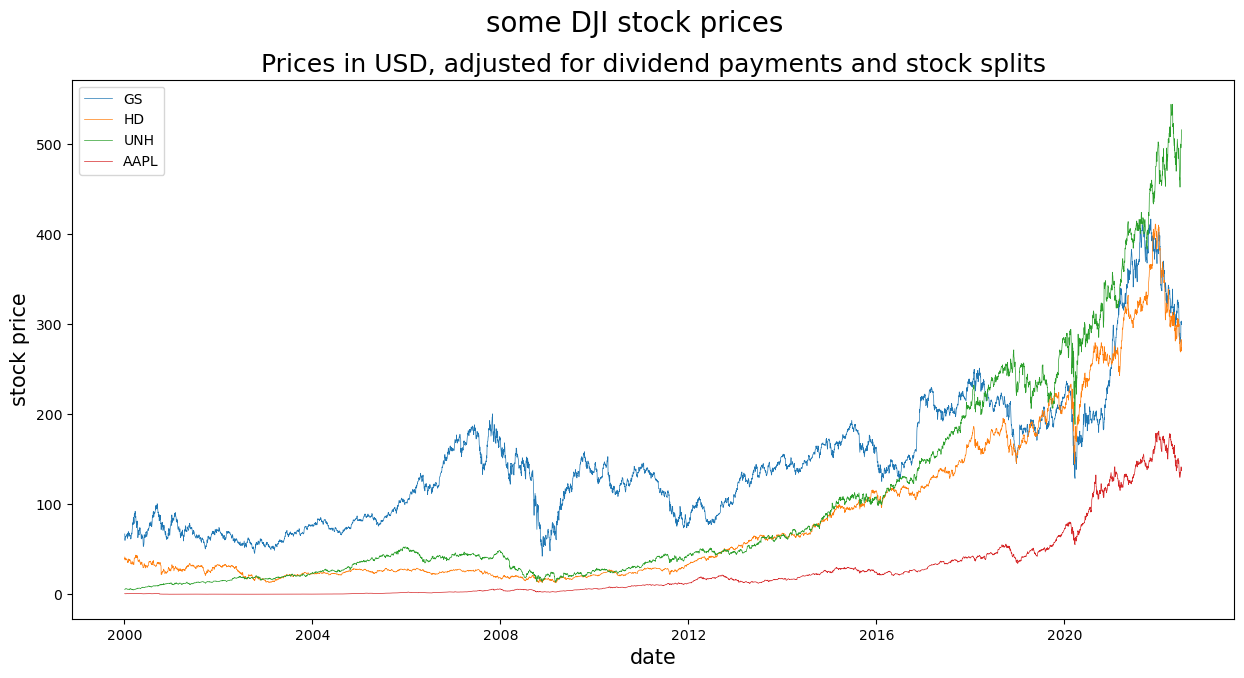

In [13]:

fig, ax = plt.subplots(figsize = (15,7))
for ind in symbol:
    ax.plot(index_prices[ index_prices["symbol"] == ind ]['date'], index_prices[ index_prices["symbol"] == ind ]['adjusted'], linewidth=0.5,label=ind)
fig.suptitle('some DJI stock prices',fontsize=20)
ax.set_title('Prices in USD, adjusted for dividend payments and stock splits',fontsize=18)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('stock price',fontsize=15)
ax.legend()
plt.show()

The same holds for stock returns. Before computing the returns, we use `groupby(symbol)` such that the `summary()` command is performed for each symbol individually. The same logic also applies to the computation of summary statistics: `groupby(symbol)` is the key to aggregating the time series into ticker-specific variables of interest.

In [14]:
ret_d= index_prices.groupby('symbol').apply(lambda x:x.set_index('date').pct_change(1)).adjusted
ret_d = ret_d.reset_index()
ret_d = ret_d.rename(columns = {ret_d.columns[2]:'ret'})
ret_d.groupby('symbol').apply(lambda x:x.ret.describe())

ret,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,5658.0,0.001231,0.025183,-0.518692,-0.010339,0.000895,0.013141,0.139050
GS,5658.0,0.000535,0.023256,-0.189596,-0.010168,0.000316,0.011161,0.264678
HD,5658.0,0.000524,0.019386,-0.287356,-0.008119,0.000512,0.009240,0.140666
UNH,5658.0,0.000998,0.019892,-0.186362,-0.008149,0.000811,0.009919,0.347550


## Other forms of data aggregation

Of course, aggregation across other variables than `symbol` can make sense as well. For instance, suppose you are interested in answering the question: are days with high aggregate trading volume likely followed by days with high aggregate trading volume? To provide some initial analysis on this question, we take the downloaded data and compute aggregate daily trading volume for all Dow Jones constituents in USD. 
Recall that the column *volume* is denoted in the number of traded shares.\index{Trading volume}
Thus, we multiply the trading volume with the daily closing price to get a proxy for the aggregate trading volume in USD. Scaling by `1e9` denotes daily trading volume in billion USD.  

In [15]:
index_prices['volume_USD']=index_prices['volume']*index_prices['close']/1e9
volume=index_prices.groupby('date').apply(lambda x:x.volume_USD.sum()).rename('volume')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


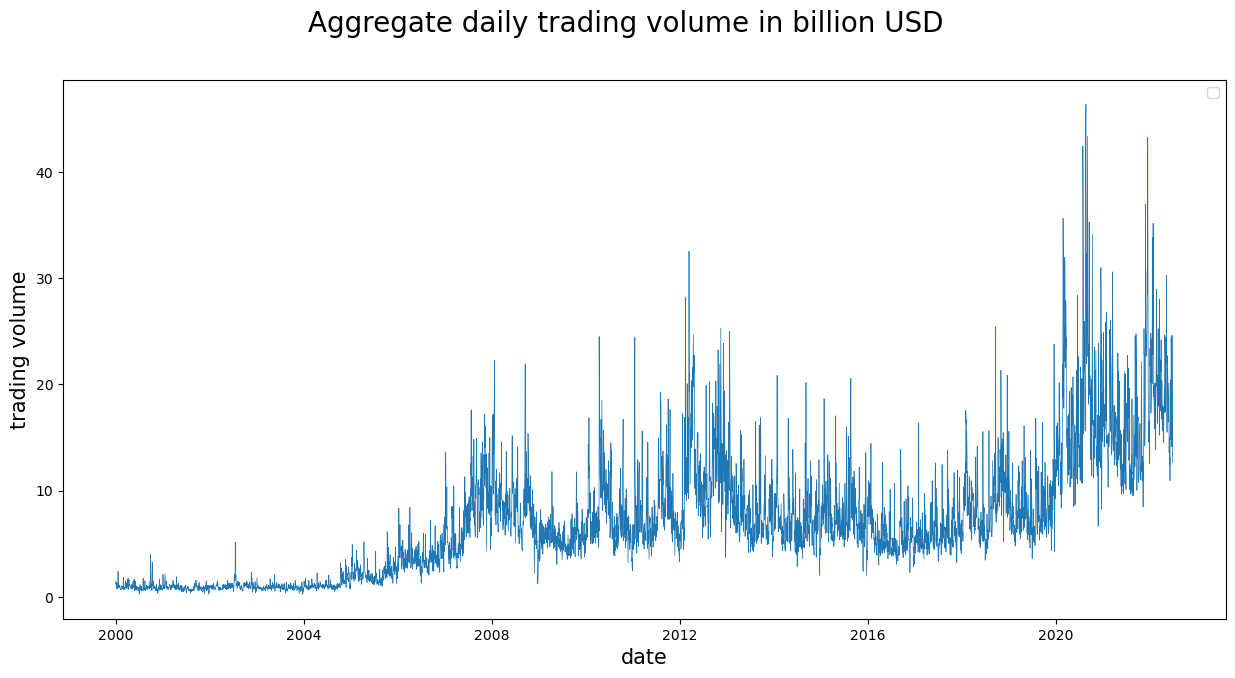

In [16]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(volume,linewidth=0.5)
fig.suptitle('Aggregate daily trading volume in billion USD',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('trading volume',fontsize=15)
ax.legend()
plt.show()

The figure indicates a clear upwards trend in aggregated daily trading volume. In particular since the outbreak of COVID-19 pandemic do markets process huge trading volume, as analyzed for instance by [Goldstein2021](https://doi.org/10.1093/rfs/hhab085).
One way to illustrate the persistence of trading volume would be to plot volume on day $t$ against volume on day $t-1$ as in the example below. We add a dotted 45°-line to indicate a hypothetical one-to-one relation by `ax.plot([0, 1], [0, 1], transform=ax.transAxes)`, addressing potential differences in the axes' scales.

In [17]:
volume=pd.DataFrame(volume)
volume['vol_lag']=volume['volume'].shift(1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


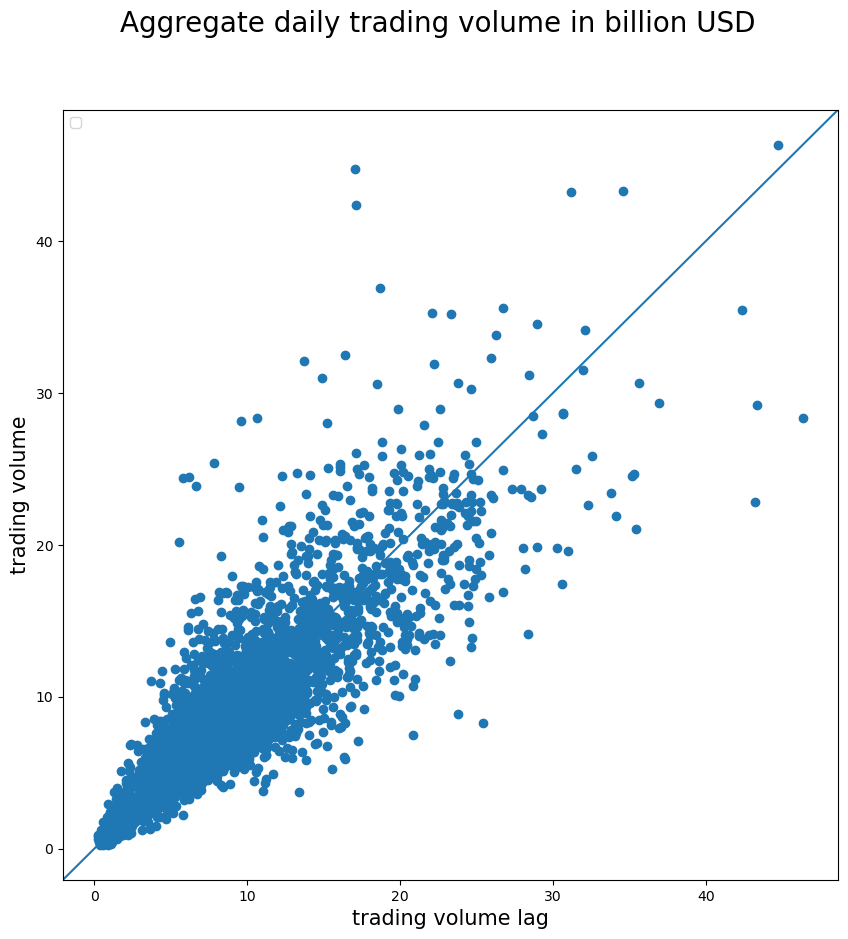

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(volume['vol_lag'],volume['volume'])
fig.suptitle('Aggregate daily trading volume in billion USD',fontsize=20)
ax.set_xlabel('trading volume lag',fontsize=15)
ax.set_ylabel('trading volume',fontsize=15)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.legend()
plt.show()

## Portfolio choice problems

In the previous part, we show how to download stock market data and inspect it with graphs and summary statistics. 
Now, we move to a typical question in Finance, namely, how to optimally allocate wealth across different assets.The standard framework for optimal portfolio selection considers investors that prefer higher future returns but dislike future return volatility (defined as the square root of the return variance): the *mean-variance investor* [Markowitz1952](Portfolio Selection). 

An essential tool to evaluate portfolios in the mean-variance context is the *efficient frontier*, the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same volatility (the square-root of the variance, i.e., the risk), see, e.g., [Merton1972](https://doi.org/10.2307/2329621). 
We compute and visualize the efficient frontier for several stocks. 
First, we extract each asset's *monthly* returns. 
In order to keep things simple, we work with a balanced panel and exclude tickers for which we do not observe a price on every single trading day since 2000.

In [19]:
# Turn dataframe into a balanced data
index_prices=index_prices.set_index('symbol')
index_prices = index_prices.set_index('date', append=True).unstack().stack(dropna=True)

In [20]:
index_prices=index_prices.reset_index().set_index('date')

In [21]:
index_prices

,symbol,open,high,low,close,adjusted,volume,volume_USD
date,,,,,,,,
2000-01-03,AAPL,0.936384,1.004464,0.907924,0.999442,0.853356,535796800,0.535498
2000-01-04,AAPL,0.966518,0.987723,0.903460,0.915179,0.781409,512377600,0.468917
2000-01-05,AAPL,0.926339,0.987165,0.919643,0.928571,0.792843,778321600,0.722727
2000-01-06,AAPL,0.947545,0.955357,0.848214,0.848214,0.724232,767972800,0.651405
2000-01-07,AAPL,0.861607,0.901786,0.852679,0.888393,0.758538,460734400,0.409313
...,...,...,...,...,...,...,...,...
2022-06-23,UNH,494.950012,503.579987,491.959991,499.809998,499.809998,4687700,2.342959
2022-06-24,UNH,499.440002,499.760010,486.559998,495.640015,495.640015,15861100,7.861396
2022-06-27,UNH,492.829987,511.890015,492.579987,505.660004,505.660004,3907100,1.975664


In [22]:
index_prices_m=index_prices.groupby('symbol').resample('M').last().drop(columns=['symbol'])

In [23]:
index_prices_m=index_prices_m.reset_index()

In [24]:
ret_m=index_prices_m.groupby('symbol').apply(lambda x:x.set_index('date').pct_change(1)).reset_index()[['symbol','date','adjusted']].dropna()

In [25]:
ret_m

,symbol,date,adjusted
1,AAPL,2000-02-29,0.104820
2,AAPL,2000-03-31,0.184842
3,AAPL,2000-04-30,-0.086517
4,AAPL,2000-05-31,-0.322922
5,AAPL,2000-06-30,0.247024
...,...,...,...
1075,UNH,2022-02-28,0.006983
1076,UNH,2022-03-31,0.074829
1077,UNH,2022-04-30,-0.002784
1078,UNH,2022-05-31,-0.023144


Next, we transform the returns from a tidy tibble into a $(T \times N)$ matrix with one column for each of the $N$ tickers to compute the sample average return vector $$\hat\mu = \frac{1}{T}\sum\limits_{t=1}^T r_t$$ where $r_t$ is the $N$ vector of returns on date $t$ and the sample covariance matrix $$\hat\Sigma = \frac{1}{T-1}\sum\limits_{t=1}^T (r_t - \hat\mu)(r_t - \hat\mu)'$$. 
We achieve this by using `.cov()` with the new column names from the column `symbol` and setting the values to `ret`.
We compute the vector of sample average returns and the sample variance-covariance matrix, which we consider as proxies for the parameters of the distribution of future stock returns. 
Thus, for simplicity we refer to $\Sigma$ and $\mu$ instead of explictly highlighting that the sample moments are estimates. \index{Covariance} In later chapters, we discuss the issues that arise once we take estimation uncertainty into account. 

In [26]:
import numpy as  np
mu=ret_m.groupby('symbol').mean().values
sigma=ret_m.set_index(['date','symbol']).unstack().cov()
var=ret_m.set_index(['date','symbol']).unstack().var()
returns_matrix=ret_m.set_index(['date','symbol']).unstack().values

Then, we compute the minimum variance portfolio weights $\omega_\text{mvp}$ as well as the expected portfolio return $\omega_\text{mvp}'\mu$ and volatility $\sqrt{\omega_\text{mvp}'\Sigma\omega_\text{mvp}}$ of this portfolio. 
\index{Minimum variance portfolio} Recall that the minimum variance portfolio is the vector of portfolio weights that are the solution to 
$$\omega_\text{mvp} = \arg\min w'\Sigma w \text{ s.t. } \sum\limits_{i=1}^Nw_i = 1.$$
The constraint that weights sum up to one simply implies that all funds have to distributed across the available asset universe, there is no possible to retain cash. 
It is easy to show analytically, that $\omega_\text{mvp} = \frac{\Sigma^{-1}\iota}{\iota'\Sigma^{-1}\iota}$ where $\iota$ is a vector of ones and $\Sigma^{-1}$ is the inverse of $\Sigma$. Note, that $\iota'\Sigma^{-1}\iota = \sum\limits_{j=1}^N\sum\limits_{i = 1}^N \sigma_{ij}$ where $\sigma_{ij}$ is the $(i,j)$-th element of $\Sigma$.

In [27]:
N=returns_matrix.shape[1]
iota = np.ones(N)
mvp_weights = np.dot(np.linalg.inv(sigma) , iota)
mvp_weights = mvp_weights / mvp_weights.sum()
mvp_weights=mvp_weights

In [28]:
expected_ret = float(np.dot(mvp_weights.T,mu))
volatility = np.sqrt(np.dot(np.dot(mvp_weights.T, sigma),mvp_weights))

In [29]:
print(expected_ret)
print(volatility)

0.015307381224867378
0.05318961830804558


Next, we set out to find the weights for a portfolio that achieves three times the expected return of the minimum variance portfolio. 
However, mean-variance investors are not interested in any portfolio that achieves the required return but rather in the efficient portfolio, i.e., the portfolio with the lowest standard deviation. 
If you wonder where the solution $\omega_\text{eff}$ comes from:The efficient portfolio is chosen by an investor who aims to achieve minimum variance *given a minimum acceptable expected return* $\bar{\mu}$. Hence, their objective function is to choose $\omega_\text{eff}$ as the solution to
$$\omega_\text{eff}(\bar{\mu}) = \arg\min w'\Sigma w \text{ s.t. } w'\iota = 1 \text{ and } \omega'\mu \geq \bar{\mu}.$$
The code below implements the analytic solution to this optimization problem for a benchmark return $\bar\mu$ which we set to 3 times the expected return of the minimum variance portfolio. We encourage you to verify that it is correct. 

In [30]:
mu_bar = 3 * mvp_weights.T.dot(mu)

C = float(iota.T.dot(np.linalg.inv(sigma)).dot(iota))
D = float(iota.T.dot(np.linalg.inv(sigma)).dot(mu))
E = float(mu.T.dot(np.linalg.inv(sigma)).dot(mu))

lambda_tilde = float(2 * (mu_bar - D / C) / (E - D**2 / C))

efp_weights = mvp_weights.reshape(4,1) + lambda_tilde / 2 * (np.linalg.inv(sigma).dot(mu) - (D *mvp_weights).reshape(4,1))
efp_weights

array([[ 1.36345626],
       [-0.98964285],
       [-0.78404303],
       [ 1.41022962]])

In [31]:
vol_bar=np.sqrt(np.dot(np.dot(efp_weights.T, sigma),efp_weights))

## The efficient frontier 

The two mutual fund separation theorem states that as soon as we have two efficient portfolios (such as the minimum variance portfolio $w_{mvp}$ and the efficient portfolio for a higher required level of expected returns $\omega_\text{eff}(\bar{\mu})$ like above), we can characterize the entire efficient frontier by combining these two portfolios. 
That is, any linear combination of the two portfolio weights will again represent an efficient portfolio. 
The code below implements the construction of the *efficient frontier*, which characterizes the highest expected return achievable at each level of risk. To understand the code better, make sure to familiarize yourself with the inner workings of the `for` loop.

In [32]:
c = np.arange(-0.4,1.9,0.01)
res=pd.DataFrame(columns=['c','mu','sd'])

In [33]:
w = (1 - 0.4) * mvp_weights + (0.4) * efp_weights.reshape(4,)
muu = 12 * 100 * w.T.dot(mu) 
sdd = 12 * np.sqrt(100) * np.sqrt(w.T.dot(sigma).dot(w))
temp=pd.DataFrame({'c':0.4,'mu':muu,'sd':sdd},index=[0])

In [34]:
for i in c:
    w = (1 - i) * mvp_weights + (i) * efp_weights.reshape(4,)
    muu = 12 * 100 * w.T.dot(mu) 
    sdd = 12 * np.sqrt(100) * np.sqrt(w.T.dot(sigma).dot(w))
    temp=pd.DataFrame({'c':i,'mu':muu,'sd':sdd},index=[0])
    res=res.append(temp, ignore_index=True)


The code above proceeds in two steps: First, we compute a vector of combination weights $c$ The code above proceeds in two steps: First, we compute a vector of combination weights $c$ and then we evaluate the resulting linear combination with $c\in\mathbb{R}_+$:   
$$w^* = cw_\text{eff}(\bar\mu) + (1-c)w_{mvp} = \omega_\text{mvp} + \frac{\lambda^*}{2}\left(\Sigma^{-1}\mu -\frac{D}{C}\Sigma^{-1}\iota \right)$$ 

with $\lambda^* = 2\frac{c\bar\mu + (1-c)\tilde\mu - D/C}{E-D^2/C}$. 


Finally, it is simple to visualize the efficient frontier alongside the two efficient portfolios within one, powerful figure using `matpltlib`. We also add the individual stocks in the same call. 
We compute annualized returns based on the simple assumption that monthly returns are iid distributed. Thus, the average annualized return is just 12 times the expected monthly return.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


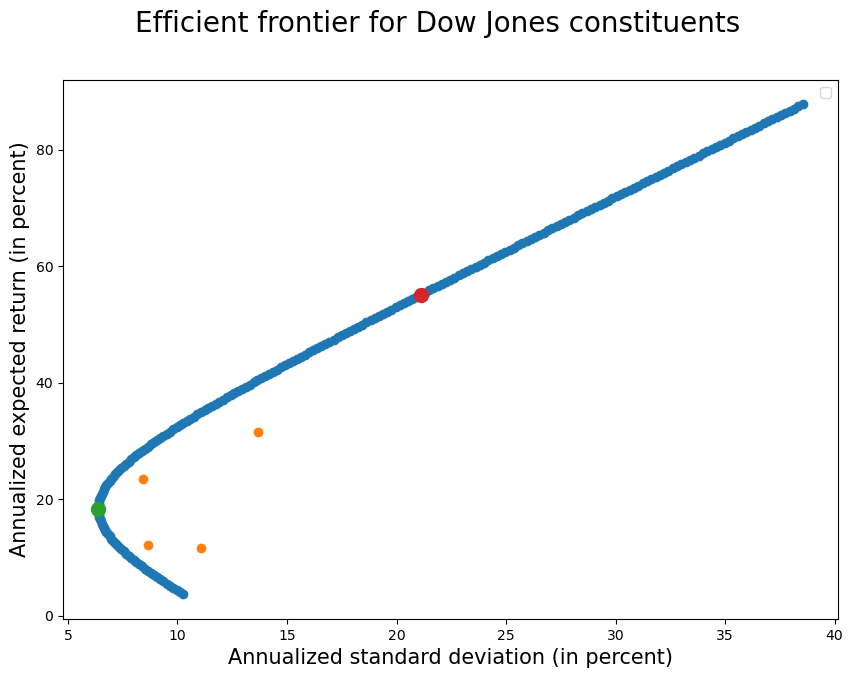

In [35]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(res['sd'],res['mu'])
ax.scatter(np.sqrt(var)*12*10,mu*12*100)
ax.scatter(volatility*12*10,expected_ret*12*100,s=100)
ax.scatter(vol_bar*12*10,mu_bar*12*100,s=100)
fig.suptitle('Efficient frontier for Dow Jones constituents',fontsize=20)
ax.set_xlabel('Annualized standard deviation (in percent)',fontsize=15)
ax.set_ylabel('Annualized expected return (in percent)',fontsize=15)
ax.legend()
plt.show()